In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# default DFN model
model = pybamm.lithium_ion.DFN()
sim = pybamm.Simulation(model)
sim.solve([0, 3600]) # run the simulation for 3600s = 1hr

sim.plot(["Current [A]", "Voltage [V]"]) # plot the results

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

['Time [s]', 'Time [min]', 'Time [h]', 'x [m]', 'x_n [m]', 'x_s [m]', 'x_p [m]', 'r_n [m]', 'r_p [m]', 'Current variable [A]', 'Total current density [A.m-2]', 'Current [A]', 'C-rate', 'Discharge capacity [A.h]', 'Throughput capacity [A.h]', 'Discharge energy [W.h]', 'Throughput energy [W.h]', 'Porosity', 'Negative electrode porosity', 'X-averaged negative electrode porosity', 'Separator porosity', 'X-averaged separator porosity', 'Positive electrode porosity', 'X-averaged positive electrode porosity', 'Porosity change', 'Negative electrode porosity change [s-1]', 'X-averaged negative electrode porosity change [s-1]', 'Separator porosity change [s-1]', 'X-averaged separator porosity change [s-1]', 'Positive electrode porosity change [s-1]', 'X-averaged positive electrode porosity change [s-1]', 'Negative electrode interface utilisation variable', 'X-averaged negative electrode interface utilisation variable', 'Negative electrode interface utilisation', 'X-averaged negative electrode in

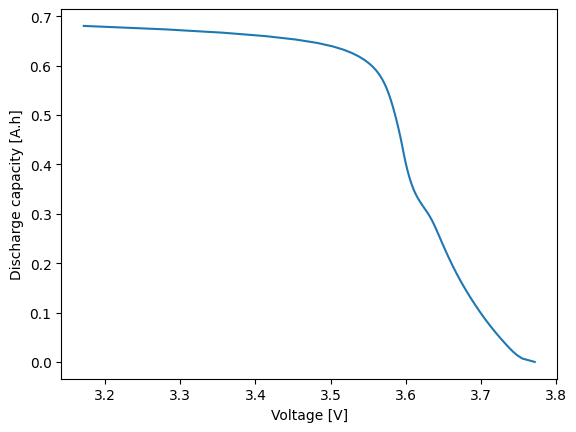

In [3]:
# list all model variables (we can also search for)
print(model.variable_names())
print('\n')
print(model.variables.search("capacity")) # select - Discharge capacity [A.h]
# sim.plot([["Current [A]", "Discharge capacity [A.h]"], "Voltage [V]"])

# let us store the simulation results
solution = sim.solution
voltage = solution["Voltage [V]"].data # get as 1d numpy array
# print(solution["Voltage [V]"](t=1200)) # voltage value at time t = 1200s
# print(voltage)
discharge_capacity = solution["Discharge capacity [A.h]"].data


plt.plot(voltage, discharge_capacity)
plt.xlabel('Voltage [V]')
plt.ylabel('Discharge capacity [A.h]')
plt.show()

In [4]:
numCycles = 3
CCCV = pybamm.Experiment([
    (
        f"Discharge at 1C until 2.5V",
        "Rest for 1 hour",
        f"Charge at 2C until 4.2V",
        "Hold at 4.2V until C/50"
    ),
] * numCycles)
model = pybamm.lithium_ion.SPMe()
parameter_values = pybamm.ParameterValues("Chen2020")
sim = pybamm.Simulation(model, experiment=CCCV, parameter_values=parameter_values)
sim.solve()
sim.plot(["Terminal voltage [V]", "Current [A]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=10.893474694101899, step=0.10893474694101898…

In [5]:
constPower = pybamm.Experiment([
    ("Discharge at 5A until 2.5V",
    "Charge at 15W until 4.2V",
    "Hold at 4.2V until 0.01A")
])
sim = pybamm.Simulation(model, experiment=constPower, parameter_values=parameter_values)
sim.solve()
sim.plot(["Current [A]", "Terminal power [W]", "Terminal voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=3.791264749294181, step=0.037912647492941806…

In [6]:
initialSOC = pybamm.Experiment([("Charge at 1C until 4.2V", "Hold at 4.2V until C/50")])
sols = []
initial_socs = [0,0.2,0.4,0.6,0.8]
for initial_soc in initial_socs:
  sim = pybamm.Simulation(model, parameter_values=parameter_values, experiment=initialSOC)
  sol = sim.solve(initial_soc=initial_soc)
  sols.append(sol)
pybamm.dynamic_plot(sols,labels=[f"initial soc = {x}" for x in initial_socs])

interactive(children=(FloatSlider(value=0.0, description='t', max=1.9431187424372194, step=0.01943118742437219…

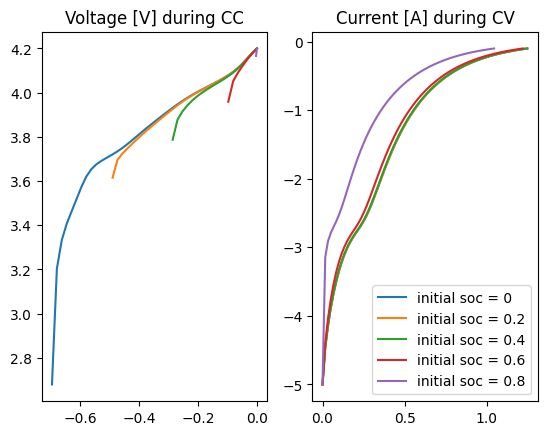

In [7]:
fig, ax = plt.subplots(1,2)
for sol in sols:
    cc = sol.cycles[0].steps[0]
    cv = sol.cycles[0].steps[1]
    t_cc = cc["Time [h]"].data
    t_cv = cv["Time [h]"].data
    ax[0].plot(t_cc-t_cv[0], cc["Terminal voltage [V]"].data)
    ax[0].set_title("Voltage [V] during CC")
    ax[1].plot(t_cv-t_cv[0], cv["Current [A]"].data)
    ax[1].set_title("Current [A] during CV")
    ax[1].legend([f"initial soc = {x}" for x in initial_socs])
plt.show()

In [18]:
parameter_values = pybamm.ParameterValues("Mohtat2020")
parameter_values.update({"SEI kinetic rate constant [m.s-1]": 1e-14})
spm = pybamm.lithium_ion.SPM({"SEI": "ec reaction limited"})
numCycles = 100
experiment = pybamm.Experiment([
    ("Charge at 1C until 4.2V",
     "Hold at 4.2V until C/50",
     "Discharge at 1C until 2V",
     "Rest for 1 hour")
] * 200,
# termination="80% capacity"
)
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()
sim.plot(['Voltage [V]', 'Current [A]'])

2024-10-09 18:41:48.019 - [ERROR] callbacks.on_experiment_error(233): Simulation error: Could not determine which event was triggered (possibly due to NaNs)


interactive(children=(FloatSlider(value=0.0, description='t', max=20.03546718699027, step=0.20035467186990272)…

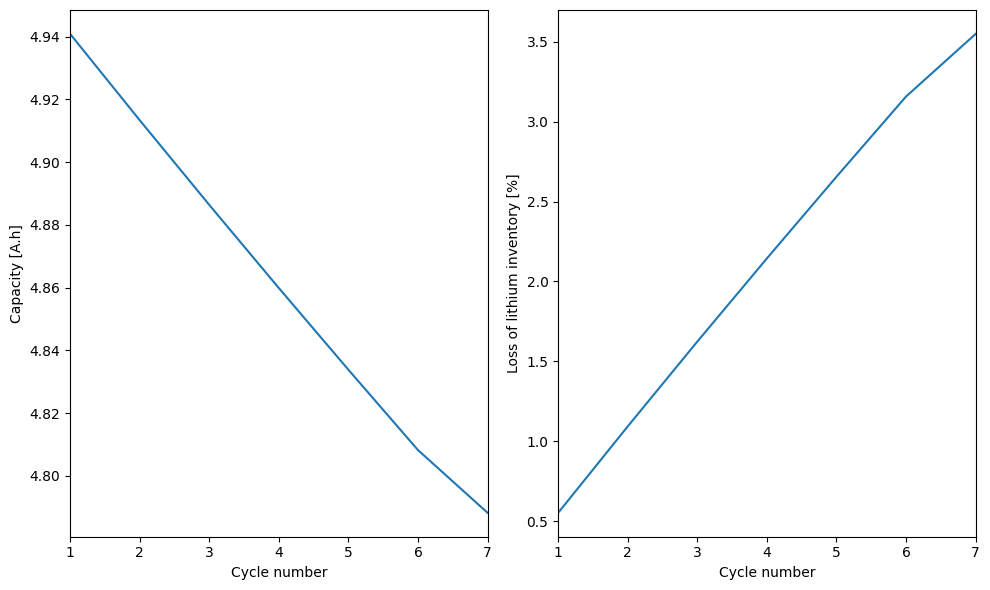

In [19]:
vars_to_plot = [
    "Capacity [A.h]",
    "Loss of lithium inventory [%]",
    # "x_100",
    # "x_0",
    # "y_100",
    # "y_0"
]
l = len(vars_to_plot)
n = int(l//np.sqrt(l))
m = int(np.ceil(l/n))
fig, axes = plt.subplots(n,m,figsize=(10,6))
for var, ax in zip(vars_to_plot,axes.flat):
    ax.plot(sol.summary_variables["Cycle number"], sol.summary_variables[var])
    ax.set_xlabel("Cycle number")
    ax.set_ylabel(var)
    ax.set_xlim([1,sol.summary_variables["Cycle number"][-1]])
fig.tight_layout()
plt.show()

In [27]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

# Load parameter values and update SEI parameters
parameter_values = pybamm.ParameterValues("Mohtat2020")
parameter_values.update({
    "SEI kinetic rate constant [m.s-1]": 1e-14,  # SEI growth rate
    "Lithium plating transfer coefficient": 0.5  # Plating transfer coefficient
})

# Define model with SEI and reversible lithium plating mechanisms
spm = pybamm.lithium_ion.SPM({
    "SEI": "ec reaction limited",  # SEI growth
    "lithium plating": "reversible",  # Lithium plating
})

# Setup experiment with cycling and degradation
numCycles = 100
experiment = pybamm.Experiment([
    ("Charge at 1C until 4.2V",      # Charge at 1C rate until the voltage reaches 4.2V
     "Hold at 4.2V until C/50",      # Hold at 4.2V until the current drops to C/50
     "Discharge at 1C until 2V",     # Discharge at 1C until the voltage reaches 2V
     "Rest for 1 hour")              # Rest for 1 hour
] * numCycles, termination="80% capacity")  # Repeat for 100 cycles or until 80% capacity

# Set up simulation and solve
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

# Plot the solution automatically (PyBaMM default plots)
sol.plot()

# Optional: Plot specific degradation-related variables
vars_to_plot = [
    "Capacity [A.h]",                               # Battery capacity over cycles
    "Loss of lithium to SEI [mol]",                 # Lithium loss to SEI formation
    "Loss of lithium to lithium plating [mol]",     # Lithium loss due to lithium plating
    "X-averaged total SEI thickness [m]",           # Average SEI layer thickness over time
    "Terminal voltage [V]"                          # Terminal voltage over time
]

# Create subplots for custom variables
fig, axes = plt.subplots(3, 2, figsize=(12, 8))  # Adjust the grid size (3 rows, 2 columns)
axes = axes.flatten()  # Flatten axes to loop through

for var, ax in zip(vars_to_plot, axes):
    ax.plot(sol.summary_variables["Cycle number"], sol.summary_variables[var])
    ax.set_xlabel("Cycle number")
    ax.set_ylabel(var)
    ax.set_xlim([1, sol.summary_variables["Cycle number"][-1]])

fig.tight_layout()
plt.show()


KeyError: "'Exchange-current density for stripping [A.m-2]' not found. Best matches are ['Exchange-current density for plating [A.m-2]', 'SEI reaction exchange current density [A.m-2]', 'Positive electrode exchange-current density [A.m-2]']"

In [ ]:
# Plotting summary variables (shows how battery degrades over time)
vars_to_plot = [
    "Capacity [A.h]",
    "Loss of lithium inventory [%]",
    "x_100",
    "x_0",
    "y_100",
    "y_0",
    "Loss of active material in negative electrode [%]",
    "Loss of lithium to lithium plating [mol]",
    "X-averaged total SEI thickness [m]"
]
l = len(vars_to_plot)
n = int(l // np.sqrt(l))
m = int(np.ceil(l / n))
fig, axes = plt.subplots(n, m, figsize=(10, 6))

for var, ax in zip(vars_to_plot, axes.flat):
    ax.plot(sol.summary_variables["Cycle number"], sol.summary_variables[var])
    ax.set_xlabel("Cycle number")
    ax.set_ylabel(var)
    ax.set_xlim([1, sol.summary_variables["Cycle number"][-1]])

fig.tight_layout()
plt.show()